# 6. Sequence modelling

In [1]:
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import *
set_notebook_preferences()

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## N-gram models

Suppose we have some observations $\{y_n\}$ which lie in in a discrete, finite space of $K$ possible states $1, 2, ... K$. Let's start by using a first order Markov model to model this data. Under a first order Markov Chain model, the likelihood of the observations is:

\begin{align}
p(y_1, y_2, ..., y_n) = p(y_1)p(y_2| y_1)...p(y_n|y_{n-1}) = p(y_1)\prod_{n = 2}^N p(y_n| y_{n-1})
\end{align}

We therefore need to know two things to pin this process down:

1. The initial measurement probability distribution $p(y_1)$.
2. The transition probability distributions $p(y_n|y_{n-1})$.

In addition, we restrict ourselves to transition probabilities $p(y_n|y_{n-1})$ which do not depend on the value of $n$. Such Markov Chains are called homogeneous, because the transition probabilities are the same throughout the chain and do not change. Knowing these two pieces of information allows us to run a generative mode or learn from data and make predictions about observations.

Let's introduce some notation for convenience: we write the initial state distribution $p(y_1 = l) = \pi_l^0$ as a vector $\boldsymbol{\pi}$ and the transition probabilites $p(y_n = k| y_{n-1} = l) = T_{kl}$ as a matrix $\mathbf{T}$, called the transition matrix. With these we can write the marginal distribution over $y_2$ as

\begin{align}
p(y_2) = \sum_{l = 1}^K p(y_2 = k | y_{1} = l)p(y_{1} = l) = \sum_{l = 1}^K T_{kl} \pi_l^0
\end{align}

and similarly over the $n^{th}$ state:

\begin{align}
p(y_n = k) &= \sum_{l = 1}^K p(y_n = k | y_{n-1} = l)p(y_{n-1} = l) = \sum_{l = 1}^K T_{kl} p(y_{n-1} = l)\\
~\\
&= \sum_{l = 1}^K T_{kl} \bigg[ \sum_{m = 1}^K T_{lm} p(y_{n-2} = m) \bigg]\\
\end{align}

and so on recursively to obtain the marginal over the $n^{th}$ state:

\begin{align}
p(y_n = k) = \big[\mathbf{T}^{n-1} \boldsymbol{\pi}\big]_k\\
\end{align}

Let's apply this to a system with $3$ discrete states, so $\boldsymbol{\pi}$ is a $3$-vector and $\mathbf{T}$ is a $3\times 3$ matrix:

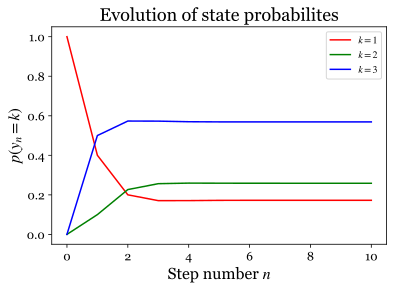

In [3]:
T = np.array([[0.4, 0.4, 0],
               [0.1, 0.2, 1/3],
               [0.5, 0.4, 2/3]]) # transition matrix

p_0 = np.array([[1, 0, 0]]).T # initial probabilities, start from state 0 

probs = [p_0] # array for probability distributions of subsequent states
sequence_length = 10 # do process for 10 steps

for n in range(sequence_length):
    prob = T.dot(probs[-1]) # current probability distribution
    probs.append(prob) # store last probability distribution

probs = np.array(probs)
for i in range(3):
    plt.plot(np.arange(sequence_length + 1), probs[:, i], color = ['red', 'green', 'blue'][i],
            label = '$k = ' + str(i+1) + '$')

plt.gca().legend()
beautify_plot({"title":"Evolution of state probabilites",
               "x":"Step number $n$", "y":"$p(y_n = k)$"})
plt.show()

The intial probabilites start out from $(1, 0, 0)$ as set in ```p_0```. As the chain progresses, the probabilities appear to quickly converge to some limiting values. What do these limits depend on? We can repeat the process for different initial probabilities to see their effect:

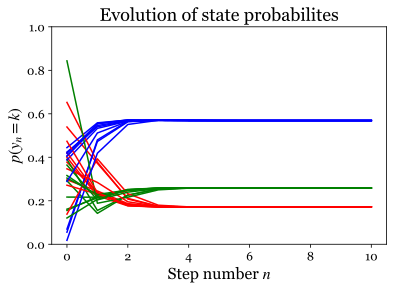

In [4]:
T = np.array([[0.4, 0.4, 0],
               [0.1, 0.2, 1/3],
               [0.5, 0.4, 2/3]]) # transition matrix

for i in range(10):
    
    p_0 = np.random.rand(3)
    p_0 = p_0/p_0.sum()

    probs = [p_0] # array for probability distributions of subsequent states
    sequence_length = 10 # do process for 10 steps

    for n in range(sequence_length):
        prob = T.dot(probs[-1]) # current probability distribution
        probs.append(prob) # store last probability distribution

    probs = np.array(probs)
    for i in range(3):
        plt.plot(np.arange(sequence_length + 1), probs[:, i],
                 color = ['red', 'green', 'blue'][i])

beautify_plot({"title":"Evolution of state probabilites",
               "x":"Step number $n$", "y":"$p(y_n = k)$"})
plt.ylim([0, 1])
plt.show()

The marginal probabilities seem to converge to the same limiting values regardless of the initial probabilites $\boldsymbol{\pi}$. It turns out that the convergent behaviour of the chain is entirely characterised by the transition matrix $\mathbf{T}$, and in particular by its eigenvalues and eigenvectors. Suppose that $\mathbf{T}$ has a complete set of eigenvectors $\{\mathbf{u}_k\}$ with corresponding eigenvalues $\{\lambda_k\}$. We can write $\mathbf{p}_n$, the vector whose $k^{th}$ entry is equal to $p(y_n = k)$, using this complete basis as:

\begin{align}
\mathbf{p}_n &= \sum_{k = 1}^K a_{nk} \mathbf{u}_k, \text{ for appropriate constants $a_{nk}$.}\\
~\\
\implies \mathbf{p}_{n + 1} &= \mathbf{T}\mathbf{p}_n = \mathbf{T}\sum_{k = 1}^K a_{nk} \mathbf{u}_k\\
~\\
&= \sum_{k = 1}^K a_{nk} \mathbf{T}\mathbf{u}_k\\
~\\
&= \sum_{k = 1}^K a_{nk} \lambda_k\mathbf{u}_k\\
\end{align}

In the limit of many applicaitons of $\mathbf{T}$ on the initial state:

\begin{align}
\mathbf{p}_{\infty} = \sum_{k = 1}^K a_{nk} \lambda_k^{\infty}\mathbf{u}_k\\
\end{align}

Any components with $|\lambda_k| < 1$ will vanish in this limit, and only components with $|\lambda_k| \geq 1$ survive. It is straightforward to show that the transition matrix cannot have eigenvalues of magnitude greater than $1$, so the only components which will survive are those with $|\lambda_k| = 1$. Therefore, if the chain converges some a steady state, it will have to be a linear combination of the eigenvectors of $\mathbf{T}$ which have unit eigenvalues. It also can be shown that at least one $|\lambda_k| = 1$ exists.

<details>
<summary>Proof of statements on transition matrix $T_{ij}$</summary>
<div>
Here we prove the statements made in the text about the transition matrix, namely: that $\mathbf{T}$ cannot have eigenvalues of magnitude greater than $1$ and that it has at least one $|\lambda_k| = 1$ exists. Consider the transition matrix $\mathbf{T}$ acting on a vector $\mathbf{v}$:
    
\begin{align}
(\mathbf{T}\mathbf{p}_n)_i = \sum_j T_{ij}p_{nj}
\end{align}

Using the fact that the column vectors of $T_{ij}$ sum to $1$ we can write:

\begin{align}
\sum_i (\mathbf{T}\mathbf{p}_n)_i = \sum_i \sum_j T_{ij}p_{nj} = \sum_j \sum_i T_{ij}p_{nj} = \sum_j p_{nj}
\end{align}

Therefore, acting on $\mathbf{p}_n$ with $\mathbf{T}$ leaves the sum of the entries in the vector unchanged, which better be so because $\mathbf{p}_n$ is itself a probability distribution over states. Remember also that since $T_{ij} > 0$ and $p_{nj} > 0$ Now if $\mathbf{T}$ had eigenvelues of magnitude greater than $1$, then in the limit of many applications of $\mathbf{T}$, the vector $\mathbf{p}_n$ would be mapped to a vector with an arbitrarily large sum of terms $> 1$, thereby contracicting the intial reuquirement that the sum of the vector's entries remains constant. Therefore $|\lambda_k| < 1$ for all eigenvalues of $\mathbf{T}$.

Similarly, for the second statement, if no $|\lambda_k| = 1$ eigenvalues existed, after several applications of $\mathbf{T}$, all entries of $\mathbf{p}_n$ would decay to $0$ which contradicts the proved statement that the sum of entries in $\mathbf{p}_n$ is constant.
</div>
</details>

Let's apply this to the previous example:

In [5]:
T = np.array([[0.4, 0.4, 0],
               [0.1, 0.2, 1/3],
               [0.5, 0.4, 2/3]]) # transition matrix

eig_values, eig_vectors = np.linalg.eig(T) # compute eigenvalues and eigenvectors of T
eig_vector = eig_vectors[:, 0]/eig_vectors[:, 0].sum()

print('Transition matrix eigenvalues:', np.real(eig_values))
print('Eigenvector with highest eigenvalue:', np.real(eig_vector))

Transition matrix eigenvalues: [ 1.          0.13333333  0.13333333]
Eigenvector with highest eigenvalue: [ 0.17241379  0.25862069  0.56896552]


As advertised, the transition matrix has an eigenvalue equal to $1$, and no eigenvalues with magnitude larger than $1$. Let's replot the marginal using $\boldsymbol{\pi} = (1, 0, 0)$, this time also plotting the probabilities of the eigenvector with eigenvalue $1.$

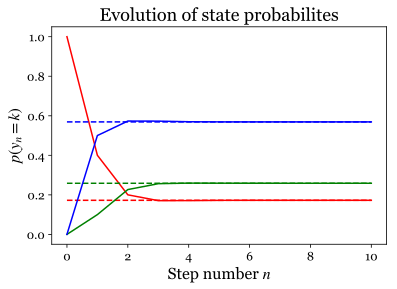

In [6]:
T = np.array([[0.4, 0.4, 0],
               [0.1, 0.2, 1/3],
               [0.5, 0.4, 2/3]]) # transition matrix

p_0 = np.array([[1, 0, 0]]).T # initial probabilities, start from state 0 

probs = [p_0] # array for probability distributions of subsequent states
sequence_length = 10 # do process for 10 steps

for n in range(sequence_length):
    prob = T.dot(probs[-1]) # current probability distribution
    probs.append(prob) # store last probability distribution

probs = np.array(probs)
eig_vector = np.real(np.linalg.eig(T)[1][:, 0]) # keep eig. vector with largest eig. value
eig_vector /= eig_vector.sum() # normalise eigenvectors so sum of entries = 1
for i in range(3):
    plt.plot(np.arange(sequence_length + 1), probs[:, i],
             color = ['red', 'green', 'blue'][i])
    plt.plot(np.arange(sequence_length + 1), 
             np.ones(shape = (sequence_length + 1,))*eig_vector[i],
             '--', color = ['red', 'green', 'blue'][i])
    
beautify_plot({"title":"Evolution of state probabilites",
               "x":"Step number $n$", "y":"$p(y_n = k)$"})
plt.show()

In this plot, the dashed lines show the entries of the eigenvector with eigenvalue $1$, and it is clear that the marginal $\mathbf{p}_n$ converges to these. Are there situations where the marginal may not converge? We have already shown that the components with $|\lambda_k| < 1$ will vanish, and only ones with $|\lambda_k| = 1$ will remain in the limit of large $n$. If all unit magnitude eigenvalues are real and positive, i.e. $\lambda_k = 1$, the marginal will converge $-$ you can show this as an excercise. If however any of the eigenvalues are negative or complex, the marginal will not converge, as the expression

\begin{align}
\mathbf{p}_{\infty} = \sum_{k = 1}^K a_{nk} \lambda_k^{\infty}\mathbf{u}_k\\
\end{align}

illustrates. Here all terms with $|\lambda_k| < 1$ would vanish and only the $|\lambda_k| = 1$ ones will remain, and if any of those $\lambda_k$'s are not equal to $1$ but are negative or complex, the value of the sum will change at each application of the matrix $\mathbf{T}$. One example of such a transition matrix is the cyclic permutation matrix:

\begin{equation}
\mathbf{T} =  \begin{pmatrix}
0 & 0 & 1\\\
1 & 0 & 0\\\
0 & 1 & 0
\end{pmatrix}.
\end{equation}

Computing the eigenvalues and eigenvectors of this matrix:

In [7]:
T = np.array([[0, 0, 1.0],
               [1.0, 0, 0],
               [0, 1.0, 0]])
T /= np.sum(T, axis = 0)

eig_values, eig_vectors = np.linalg.eig(T) # compute eigenvalues and eigenvectors of T

print('Eigenvalues:\n', np.real(eig_values))
print('Eigenvectors:\n', eig_vectors)

Eigenvalues:
 [-0.5 -0.5  1. ]
Eigenvectors:
 [[-0.28867513+0.5j -0.28867513-0.5j -0.57735027+0.j ]
 [ 0.57735027+0.j   0.57735027-0.j  -0.57735027+0.j ]
 [-0.28867513-0.5j -0.28867513+0.5j -0.57735027+0.j ]]


The matrix has two complex eigenvectors (first and second columns) and a single real eigenvector (third column). This real eigenvector has all entries equal and normalising it would give $\mathbf{u}_3 = \big(1/\sqrt{3}, 1/\sqrt{3}, 1/\sqrt{3}\big)$. If we chose $\boldsymbol{\pi} = \mathbf{u}_3$, all subsequent marginals would remain equal to $\boldsymbol{\pi}$:

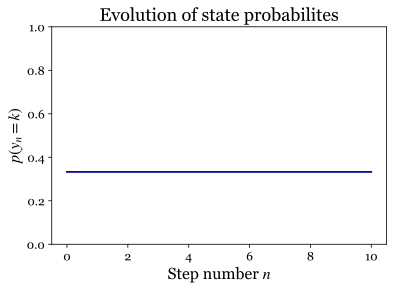

In [8]:
T = np.array([[0, 0, 1.0],
              [1.0, 0, 0],
              [0, 1.0, 0]])
T /= np.sum(T, axis = 0)
probs = np.array([[1.0, 1.0, 1.0]])
probs /= probs.sum()

sequence_length = 10
for n in range(sequence_length):
    
    prob = T.dot(probs[-1]).reshape((1, -1))
    probs = np.append(probs, prob, axis = 0)

for i in range(3):
    plt.plot(np.arange(sequence_length + 1), probs[:, i], color = ['r', 'g', 'b'][i])

beautify_plot({"title":"Evolution of state probabilites",
               "x":"Step number $n$", "y":"$p(y_n = k)$"})
plt.ylim([0, 1])
plt.show()

If however any other $\boldsymbol{\pi}$ is chosen, such as $(1, 0, 0)$, the marginal will fluctuate and never converge:

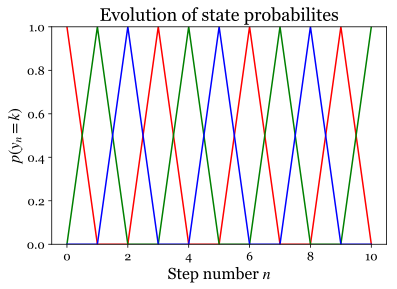

In [9]:
T = np.array([[0, 0, 1.0],
              [1.0, 0, 0],
              [0, 1.0, 0]])
T /= np.sum(T, axis = 0)
probs = np.array([[1, 0, 0]])

sequence_length = 10
for n in range(sequence_length):
    
    prob = T.dot(probs[-1]).reshape((1, -1))
    probs = np.append(probs, prob, axis = 0)

for i in range(3):
    plt.plot(np.arange(sequence_length + 1), probs[:, i], color = ['r', 'g', 'b'][i])

beautify_plot({"title":"Evolution of state probabilites",
               "x":"Step number $n$", "y":"$p(y_n = k)$"})
plt.ylim([0, 1])
plt.show()

The marginals are therefore not guaranteed to converge in the general case, although they are in the case where all unit magnitude eigenvalues are equal to $1$.

Lastly we may consider arbitrary order Markov Chains where the probability of a measurement conditioned on previous measurements reduces like:

\begin{align}
p(y_n | y_{n-1}, y_{n-2}, ... y_1) &= p(y_n | y_{n-1}), \text{ 1$^{st}$ order (bi-gram).}\\
~\\
p(y_n | y_{n-1}, y_{n-2}, ... y_1) &= p(y_n | y_{n-1}, y_{n-2}), \text{ 2$^{nd}$ order (3-gram).}\\
~\\
p(y_n | y_{n-1}, y_{n-2}, ... y_1) &= p(y_n | y_{n-1}, y_{n-2}, y_{n-3}), \text{ 3$^{rd}$ order (4-gram).}\\
~\\
&~~\vdots\\
~\\
p(y_n | y_{n-1}, y_{n-2}, ... y_1) &= p(y_n | y_{n-1}, y_{n-2},..., y_{n-m}), \text{ m$^{th}$ order.}\\
\end{align}

A Markov Chain of discrete measurements, of $N^{th}$ order is called an $N$-gram. So far we have considered bi-grams where each measurement is independent of all other measurements given its immediately previous measurement. The general $N$-gram involves higher dimensional arrays of transition probabilities like:

\begin{align}
p(y_n | y_{n-1}, y_{n-2},..., y_{n-m}) = T_{n, m, ..., l}
\end{align}

The idea here is that chains with higher orders will be able to capture more intricate correlations in the data. Next we consider the problem of learning the $N$-gram parameters, initial probabilities and transition matrices. We will work on the simplest case of bi-grams, although our approach can be easily extended to higher order $N$-grams.

## Learning the N-gram parameters

Consider the problem of learning the parameters (initial probabilities $\{\pi\}$ and transition probabilities $T_{ij}$) of a bigram model, given several sampled sequences $\{\mathbf{y}_s\}$ with $\mathbf{y}_s$ being the s$^{th}$ sampled sequence. We will do this by computing the parameters which maximize the log-likelihood. Let $y_{ns}$ be the n$^{th}$ measured value of the s$^{th}$ sequence. The likelihood and log-likelihood of the model are then:

\begin{align}
p(y_{1:T}) &= p(y_1)p(y_2|y_1)p(y_3|y_2) ... p(y_N|y_{N-1}) = p(y_1)\prod_{n = 2}^N p(y_n|y_{n - 1})\\
\mathcal{L} &= \text{log}~ p(y_{1:T}) = \text{log}~p(y_1) + \sum_{n = 2}^N \text{log}~p(y_n|y_{n - 1})
\end{align}

Substituting the expressions for $p(y_1)$ and $p(y_n|p_{n-1})$

\begin{align}
p(y_1 = k) &= \pi_k = \pi_{y_{ns}}\\
p(y_{ns} = i|y_{n-1, s} = j) &= T_{ij} = T_{y_{ns}, y_{n-1, s}},\\
\end{align}

while using Lagrange multipliers, we can show that the maximum in the log-likelihood solution takes the intuitive form:

\begin{align}
\pi_k &= \frac{c_k}{S}\\
~\\
T_{ij} &= \frac{c_{ij}}{\sum_i c_{ij}}\\
\end{align}

where $c_k$ is the number of occurances of $y_{1s} = k$ and $c_{ij}$ is the number of occurances of $(y_{ns} = i, y_{{n-1},s} = j)$ in the dataset. In other words, the maximum likelihood solution is obtained from simply counting the occurances of each initial state and each different transition, and normalising the counts.

<details>
<summary>Bi-gram maximum likelihood in detail</summary>
<div>
Starting from the bi-gram log-likelihood expression
\begin{align}
\mathcal{L} &= \text{log}~ p(y_{1:T}) = \text{log}~p(y_1) + \sum_{n = 2}^N \text{log}~p(y_n|y_{n - 1})
\end{align}

and substituting

\begin{align}
p(y_1 = k) &= \pi_k = \pi_{y_{ns}}\\
~\\
p(y_{ns} = i|y_{n-1, s} = j) &= T_{ij} = T_{y_{ns}, y_{n-1, s}},\\
\end{align}

while also using the fact that different sequences are independent from each other, so that the dataset log-likelihood is the sum of the likelihoods of individual sequences:

\begin{align}
\mathcal{L} &= \sum_{s = 1}^S\bigg[\text{log}~p(y_{1s}) + \sum_{n = 2}^N \text{log}~p(y_{ns}|y_{n - 1,s})\bigg]\\
~\\
&= \sum_{s = 1}^S\bigg[\text{log}~ \pi_{y_{ns}} + \sum_{n = 2}^N \text{log}~T_{y_{ns}, y_{n-1, s}} \bigg]\\
\end{align}

Before we extremise the above with respect to $\pi_k \text{ and } T_{ij}$, we must include Lagrangian multipliers for both these quantities, because they represent probability distributions which must remain normalised:

\begin{align}
\sum_k\pi_k &= 1 \implies \lambda_{\pi} \bigg( \sum_k\pi_k - 1 \bigg) = 0\\
~\\
\sum_i T_{ij} &= 1 \implies \lambda_{T} \bigg( \sum_i T_{ij} - 1 \bigg) = 0
\end{align}

Using these Lagrange multipliers to extremise the log-likelihood for $\pi_k$:

\begin{align}
\frac{\partial \bigg[ \mathcal{L} - \lambda_{\pi} \big(\sum_k \pi_k - 1\big) \bigg]}{\partial \pi_k} &= \sum_{y_{1s} =~k} \frac{1}{\pi_k} - \lambda_{\pi} = \frac{c_k}{\pi_k} - \lambda_{\pi} = 0\\
\end{align}

Also, using the fact that the sum of counts $c_k$ is equal to the number of sequences in the dataset, and that $\pi_k$ is normalised

\begin{align}
\sum_k c_k = S \text{ and }& \sum_k c_k = \sum_k \lambda_{\pi}\pi_k = 1\\
~\\
\implies \lambda_{\pi} &= S\\
\end{align}

we obtain the final result for $\pi_k$

\begin{align}
\pi_k = \frac{c_k}{S}\\
\end{align}

We can repeat the same process for $T_{ij}$:

\begin{align}
\frac{\partial \bigg[ \mathcal{L} - \lambda_T \big(\sum_a T_{ab} - 1\big) \bigg]}{\partial T_{ij}} &= \sum_{y_{ns} = i,~y_{n-1, s} = j} \frac{1}{T_{ij}} - \lambda_T = \frac{c_{ij}}{T_{ij}} - \lambda_T = 0\\
\end{align}

Using the property that the sum of $T_{ij}$ over $j$ must be equal to $1$:

\begin{align}
\sum_j c_{ij}  = \lambda_T \sum_j T_{ij} = \lambda_T\\
\end{align}

we obtain the final result for $T_{ij}$ by rearranging and summing over $j$

\begin{align}
T_{ij} &= \frac{c_{ij}}{\sum_i c_{ij}}\\
\end{align}

The notation $\sum_{y_{1s} =~k}$ denotes summing over the terms for which $y_{1s} =~k$, and likewise for the other sum. You can convince yourself that these sums give rise to the counts mentioned above.

</div>
</details>

Exactly the same process can be applied to higher order $N$-grams, such as the $3$-gram where we have to compute the inital probabilites $\pi_k$, first transition matrix $T_{ij}$ used only in the $y_1 \to y_2$ transition, and second transition matrix $T_{ijk}$ used in all subsequent transitions. In these higher order cases we proceed again by counting the number of relevant transitions and normalising initial probabilitues and transition matrices $-$ we will look at higher MC solutions later on in an example on text data. For the moment however, let's stick to the bi-gram case and implement the formulae above to learn the model parameters.

In [110]:
T_ = np.array([[0.4, 0.4, 0],
               [0.1, 0.2, 1/3],
               [0.5, 0.4, 2/3]])
probs = np.array([1/3, 1/3, 1/3])
S, N, K = 10, 100, probs.shape[0]

ys = []
for n in range(S):
    y_ = [np.random.choice([0, 1, 2], p = probs)]
    
    for j in range(N - 1):
        y_.append(np.random.choice([0, 1, 2], p = T_[:, y_[-1]]))
        
    ys.append(y_)
    
ys = np.array(ys).T

In [112]:
counts = np.array([(np.where(ys[0, :] == k)[0]).shape[0] for k in range(K)])
probs_learnt = counts/counts.sum()

counts = np.array([[(np.where((ys[1:, :] == i)*(ys[:-1, :] == j))[0]).shape[0] for j in range(K)] for i in range(K)])
T_learnt = counts/np.sum(counts, axis = 0)
print(probs_learnt)
print(T_learnt)

[ 0.4  0.4  0.2]
[[ 0.40853659  0.37109375  0.        ]
 [ 0.12195122  0.24609375  0.29649123]
 [ 0.4695122   0.3828125   0.70350877]]


## Example: Learning Alice's adventures in Wonderland

In this example we apply a Marov Chain model to text data, and in particular on the Alice in Wornderland novel by Lewis Caroll. In particular, we will train a model using the whole novel on a character-by-character basis. Thus we consider characters to be the observations $y_n$ and sentences, separated by full stops, will be the sequences. Our goal will be to fit an N-gram to this data, and then use it to generate new sentences to see how well it replicates the text. Let's start by importing the text:

In [113]:
text = open('alice_in_wonderland.txt', 'r').read() # load full text in one long string
chars = ''.join(sorted(set(text))) # get unique characters of text in sorted a string

print('Text contains {} characters.'.format(len(text)))
print('Text contains {} unique characters: {}'.format(len(chars), chars))

Text contains 137878 characters.
Text contains 37 unique characters:  !"(),-.:;?abcdefghijklmnopqrstuvwxyz


We split the sentences up at each full stop and print some examples:

In [124]:
sentences = np.array(text.split('.')) # split text to sentences marked by full stops
sentences = np.core.defchararray.add(sentences, ["."]) # reintroduce full stops to each sentence end
sentences = np.core.defchararray.strip(sentences) # remove leading or trailing whitespace from each sentence
char_dict = dict(zip(chars, np.arange(len(chars)))) # dictionary mapping characters to their IDs

for i in range(5):
    print('Example {}:'.format(i + 1), sentences[np.random.randint(0, 1000)], '\n')

Example 1: the king looked anxiously at the white rabbit, who said in a low voice, your majesty must cross-examine this witness. 

Example 2: and ever since that, the hatter went on in a mournful tone, he wont do a thing i ask! its always six oclock now. 

Example 3: alice could see this, as she was near enough to look over their slates; but it doesnt matter a bit, she thought to herself. 

Example 4: not quite right, im afraid, said alice, timidly; some of the words have got altered. 

Example 5: im mad. 



Let's see what an implementation of an N-gram model may look like. The function ```max_lik_seq``` can deal with the general case of any $N \geq 2$. Given a set of example sequences, it calculates the initial probabilites $\boldsymbol{\pi}$ and transition arrays $T_{k, l}$, $T_{k, l, m}$,... $T_{k, l, m, ... n}$ up to the required order.

In [115]:
def max_lik_seq(sequences, N, char_dict):
    # list for storing transition arrays and transition probs
    arrays = [np.zeros(shape = (len(char_dict),)*n) for n in range(1, N + 1)] 
    
    for sequence in sequences:
        for idx, y in enumerate(sequence): # loop over characters in a sequence
            array = arrays[min(idx, N - 1)] # select appropriate array given the position in sequence
            
            if idx == 0: # if looking at the first character in sequence
                array[char_dict[y]] += 1 # increment count of character appearing 1st in array by 1
                
            if idx > 0: # if looking at the subsequent characters in sequence
                prev_y = np.array(list(sequence[max(0, idx - N + 1): idx])) # array of chars preceeding current char
                chars = []
                
                for char in prev_y: # loop over preceeding characters...
                    chars.append(char_dict[char]) # ...store ID of each preceeding character
                chars.append(char_dict[y]) # afterwards, store ID of current char
                
                # all of the pre-processing above was done to get tuple(chars) to use as index
                array[tuple(chars)] += 1 # increment count of observations of the sequence with IDs chars
                
    for i, array in enumerate(arrays): # loop over matrices to normalise
        if i == 0:
            arrays[0] = arrays[0]/arrays[0].sum() # normalise initial probabilities
        else:
            idx = np.where(arrays[i].sum(axis = -1) > 0) # indices of entries with non-zero counts
            arrays[i][idx] = (arrays[i][idx].T/arrays[i].sum(axis = -1)[idx]).T # normalise transition arrays

    return matrices

Also, we write a convenience function ```sample_sequence``` to sample sequences using the transition arrays already learnt.

In [116]:
def sample_sequence(arrays, N, seq_length, char_dict, chars):
    sequence_str, sequence_id = '', [] # for storing sampled chars by symbol and by ID
    
    for i in range(seq_length):
        array = arrays[min(i, N - 1)]

        if i == 0:
            char = np.random.choice(list(chars), p = array) # sample first char

        else:
            select_idx = tuple(sequence_id[max(0, i - N + 1) : i]) # IDs of preceeding characters
            if abs(array[select_idx].sum() - 1) > 10**-9: # if char has low transition probability to any other...
                break # ...stop sampling
            char = np.random.choice(list(chars), p = array[select_idx]) # sample new character given preceeding ones

        sequence_str += char # store sampled character into string...
        sequence_id.append(char_dict[char]) # ...and into array using its ID
        
    return sequence_str

In [117]:
N = 5 # N chars in N-gram: N > 6 may freeze the notebook because it's too slow
matrices = max_lik_seq(sentences, N, char_dict)
for i in range(1, 11):
    print('Sample {}'.format(i), sample_sequence(matrices, N, 100, char_dict, chars))

Sample 1 she air, and the saying its fathere itll never, she hot the which was a low, vulgar the more.
Sample 2 and beautiful of life, now, said have the tiptoe, pantimpossible.
Sample 3 hold youre aloud as if herself.
Sample 4 do you conqueror.
Sample 5 last idea tone silence the both some yet, kept down, and looked at the dormouse foot a little giving
Sample 6 where was before, three garden.
Sample 7 there nor it, said thought they courtier.
Sample 8 not gone shrink me, said that saying down stairs of marchment on.
Sample 9 of the king.
Sample 10 what say and low hers changine converself it, why, i suppose that the no name the nile told you will


You can experiment with $N$ to see its effect on the N-gram. For $N = 2$ the generated samples are mostly mixed up letters, not containing any words. As $N$ incrases, the N-gram can learn longer sequences of letters, and words appear in the sample. For example when $N = 3$, short words form such as: the, he, she, said; for $N = 4$ we encounter words like: alice, that , would, self; for $N = 5$ we observe not only longer words like gryphon, enough, queen or little, but occasionally some words appear paired, for example "i can", "i dont" or "heard a". Again this is because the N-gram can learn longer correlations between sequences of characters, leading to more complex sentences.

## Autoregressive Gaussian (AR) models

We now turn our attention to continuous Markov Chains. Here, the observations $\{y_n\}$ lie in a continuous rather than a discrete space. Consider the following generative model: sample $y_1 \sim \mathcal{N}(\mu_0, \sigma^2_0)$, and continue by sampling $y_n \sim \mathcal{N}(\lambda y_{n-1}, \sigma^2)$. At each step we use the value of the previous step, scaled by a constant $\lambda$ and use this as the mean of our next sample, which should lead to a correlation between individual observations. Such models are called autoregressive gaussian or AR models. Let's start by sampling according to this recipe:

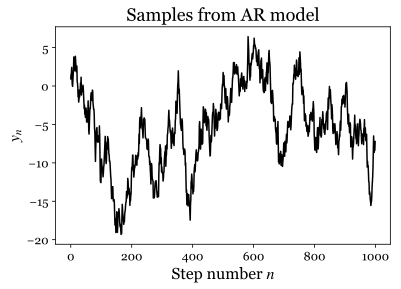

In [118]:
no_points = 10**3
mu_0, sig_0 = 0, 1 # mean and standard deviation of y_0 gaussian
lamda, sig_noise = 0.99, 1 # lamda and sigma for subsequent distributions

ys = [np.random.normal(mu_0, sig_0)] # array to store samples

for n in range(no_points - 1):
    
    next_y = np.random.normal(lamda*ys[-1], sig_noise) # sample next using previous sample and parameters
    ys.append(next_y)
    
plt.plot(ys, color = 'black')
beautify_plot({"title":"Samples from AR model", "x":"Step number $n$", "y":"$y_n$"})
plt.show()

You are encouraged to experiment with ```mu_start, sig_start, lamda, sig_noise``` to see their effect on the samples. For scaling constant $\lambda < 0$ for example, you should observe oscillations because the mean of the next sample is negatively correlated with the previous sample. Can you predict what happens the following regimes: $0 < \lambda < 1$, $\lambda > 1$ and $\lambda < -1$? We may also ask what is the behabiour of the sequence is after it has run for a long time, in the steady state limit. The general term of the sequence is

\begin{align}
y_n = \lambda y_{n - 1} + \epsilon, \text{ where }\epsilon ~ \mathcal{N}(0, \sigma^2)
\end{align}

and it can be shown that for $|\lambda| < 1$ in the limit of large $n$:

\begin{align}
\mu_{\infty} &\equiv \lim_{n \to \infty} \langle y_n \rangle = 0\\
~\\
\sigma^2_{\infty} &\equiv \lim_{n \to \infty} \langle (y_n - \langle y_n \rangle)^2 \rangle = \frac{\sigma^2}{1 - \lambda^2}\\
\end{align}

<details>
<summary>Steady state mean $\mu_{\infty}$ and variance $\sigma^2_{\infty}$ in detail</summary>
<div>
Starting from the expression
    
\begin{align}
y_n = \lambda y_{n - 1} + \epsilon_n, \text{ where }\epsilon_n ~ \mathcal{N}(0, \sigma^2)
\end{align}

and taking the expectation:

\begin{align}
\langle y_n \rangle = \lambda \langle y_{n - 1} \rangle
\end{align}

we apply this recursively to obtain:

\begin{align}
\mu_{\infty} \equiv \langle y_n \rangle = \lambda^k \langle y_{n - k} \rangle \implies \langle y_n \rangle = \lambda^{n-1} \langle y_1 \rangle
\end{align}

If $\langle y_1 \rangle = 0$, $\mu_{\infty} = 0$ always. Otherwise, in the limit of large $n$, if $|\lambda| < 1$, then $\langle y_n \rangle = 0$, whereas if $|\lambda| > 1$, the sequence will explode. Now for the variance, assuming $|\lambda| < 1$: 

\begin{align}
\sigma^2_{\infty} &\equiv \langle (y_n - \langle y_n \rangle)^2 \rangle = \langle y_n^2 \rangle = \langle y_n^2 \rangle = \langle(\lambda y_{n - 1} + \epsilon_n)^2\rangle\\
~\\
&= \langle \lambda^2 y_{n - 1}^2 + 2\lambda \epsilon_n y_{n - 1} + \epsilon_n^2\rangle
\end{align}

Using the fact that $\epsilon_n$ and $y_{n-1}$ are independent, $\langle \epsilon_n y_{n - 1} \rangle = \langle \epsilon_n\rangle\langle y_{n - 1} \rangle$:

\begin{align}
\sigma^2_{\infty} &= \langle \lambda^2 y_{n - 1}^2 + 2\lambda \epsilon_n y_{n - 1} + \epsilon_n^2\rangle\\
~\\
&= \langle \lambda^2 y_{n - 1}^2 \rangle + 2\lambda \langle \epsilon_n y_{n - 1}\rangle + \langle \epsilon_n^2\rangle\\
~\\
&= \lambda^2 \sigma^2_{\infty} + \sigma^2\\
~\\
\implies \sigma^2_{\infty} &= \frac{\sigma^2}{1 - \lambda^2}
\end{align}

arriving at the expression we saw before. It is interesting to note that as $\lambda^2 \to 1$, $\sigma^2_{\infty} \to \infty$, as the transition between $|\lambda| < 1$ and $|\lambda| > 1$ is made.


It is also interesting to note that the special case $\lambda = 1$ is a continuous random walk in $1$ dimension, for which it can be shown that $\langle y_n \rangle = 0, \langle y_n^2 \rangle = n\sigma^2$, so the variance of the observations increases without bound with $n$. The proof is essentially the same recursive argument we used before, in the special case of $\lambda = 1$:

\begin{align}
y_n &= y_{n - 1} + \epsilon_n\\
~\\
y_n &= \sum_{k = 1}^n \epsilon_k\\
~\\
\langle y_n^2 \rangle &= \bigg \langle \bigg[ \sum_{k = 1}^n \epsilon_k \bigg]^2 \bigg \rangle\\
~\\
&= \bigg \langle \sum_{k = 1}^n \epsilon_k^2 + \sum_{j \neq k} \epsilon_j\epsilon_k \bigg \rangle\\
~\\
&= n \sigma^2
\end{align}

where again we have used the fact that $\epsilon_j, \epsilon_k, i \neq j$ are independent variables.

</div>
</details>

Let's calculate the $\mu_{\infty}, \sigma^2_{\infty}$ using these formulae and also directly from the sampled distributions to see how they compare.

In [119]:
ys = np.array(ys)
print('Theoretical mean: ', 0, '\nTheoretical variance: ', round(1/(1 - lamda**2), 3),
      '\nSample mean: ', round(ys.mean(), 3), '\nSample variance: ', round(ys.var(), 3))

Theoretical mean:  0 
Theoretical variance:  50.251 
Sample mean:  -5.491 
Sample variance:  28.947


So the theoretical and numerical means and variances of the stationary distribution agree $-$ taking more samples by increasing ```no_points``` makes the agreement closer. An notable property of AR models is that they are equivalent to a single multivariate gaussian. Consider the likelihood of the AR, where for notational simplicity we will assume $\mu_0 = 0$ and $\sigma^2_0 = \sigma^2$:

\begin{align}
p(y_{1:N}) &= p(y_1)p(y_2|y_1)p(y_3|y_2) ... p(y_N|y_{N-1}) = p(y_1)\prod_{n = 2}^N p(y_n|y_{n - 1})\\
\end{align}

\begin{align}
p(y_n|y_{n - 1}) &= \mathcal{N}(y_n; \lambda y_{n - 1}, \sigma^2) \propto \text{exp}\bigg(-\frac{1}{2\sigma^2}(y_n - \lambda y_{n-1})^2\bigg)\\
~\\
p(y_1) &= \mathcal{N}(y_1; \mu_0, \sigma_0^2) \propto \text{exp}\bigg(-\frac{y_1^2}{2\sigma^2}\bigg)\\
\end{align}

Therefore the log-likelihood $\mathcal{L} = \text{log}~p(y_{1:N})$ assumes a quadratic form:

\begin{align}
\mathcal{L} &= -\frac{1}{2\sigma^2}\bigg[ y_1^2 + \sum_{n = 2}^N (y_n - \lambda y_{n - 1})^2 \bigg] + \text{ const.}\\
\end{align}

By looking at the sum above, we see that every quadratic term $y_n^2$ has coefficient $1 + \lambda^2$, except for $y_N^2$ whose coefficient is $1$. All other terms in the sum are linear in the $y_n$'s and are of the form $-2\lambda y_n y_{n - 1}$ for $n = 2, 3 ..., N$. It can be seen by inspection that this quadratic form can be expressed in matrix form as:

\begin{equation}
\mathcal{L} = -\frac{1}{2\sigma^2} \mathbf{y}^{\top}\mathbf{Q}\mathbf{y}, \text{ where } \mathbf{Q} = \begin{pmatrix}
1 + \lambda^2 & -\lambda & 0 & \cdots & 0\\\
-\lambda & 1 + \lambda^2 & -\lambda & \cdots & 0\\\
0 & -\lambda & 1 + \lambda^2 & \cdots & 0\\\
\vdots & \vdots & \vdots & \ddots & \vdots\\\
0 & 0 & 0 & \cdots & 1
\end{pmatrix},~~\mathbf{y} = \begin{pmatrix}
y_1\\\
y_2\\\
y_3\\\
\vdots\\\
y_N
\end{pmatrix}.
\end{equation}

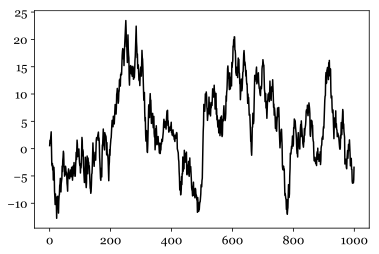

In [120]:
no_points = 10**3

mu_0, sig_0 = 0, 1 # mean and standard deviation of y_0 gaussian
lamda, sig_noise = 0.99, 1 # lamda and sigma for subsequent distributions

prec = np.eye(no_points)*(1 + lamda**2)
idx = np.arange(no_points)
prec[idx[:-1], idx[1:]] = -2*lamda
prec[-1, -1] = 1
prec = 1/(2*sig_noise**2)*(prec + prec.T)/2

cov = np.linalg.inv(prec)
mu = np.zeros(shape = (no_points,))

ys = np.random.multivariate_normal(mu, cov)
plt.plot(ys, color = 'black')
plt.show()

In [121]:
print('Sample mean: ', ys.mean(), '\nSample variance: ', ys.var(),
      '\nTheoretical mean: ', 0, '\nTheoretical variance: ', sig_noise**2/(1 - lamda**2))

Sample mean:  3.63383938194 
Sample variance:  55.1363051976 
Theoretical mean:  0 
Theoretical variance:  50.25125628140696


## Learning the AR parameters

Next we look at the problem of learning the parameters ($\mu_0, \sigma_0, \lambda, \sigma$) of an AR model, given several sampled sequences $\{\mathbf{y}_s\}$ with $\mathbf{y}_s$ being the s$^{th}$ sampled sequence. Similarly to the N-gram case we proceed by computing the model parameters ($\mu_0, \sigma_0, \lambda, \sigma$ in this case) which maximize the log-likelihood. Let $y_{ns}$ be the n$^{th}$ measured value of the s$^{th}$ sequence, with $s = 1, 2, ... S$. The likelihood and log-likelihood of the model are then:

\begin{align}
p(y_{1:T}) &= p(y_1)p(y_2|y_1)p(y_3|y_2) ... p(y_N|y_{N-1}) = p(y_1)\prod_{n = 2}^N p(y_n|y_{n - 1})\\
\mathcal{L} &= \text{log}~ p(y_{1:T}) = \text{log}~p(y_1) + \sum_{n = 2}^N \text{log}~p(y_n|y_{n - 1})
\end{align}

Differentiating the log-likelihood with respect to the model parameters and settin the derivatives equal to $0$ gives the closed form solution:

\begin{align}
\mu_0 &= \frac{\sum_{s = 1}^S y_{1s}}{S},~\sigma_0^2 = \frac{\sum_{s = 1}^S (y_{1s} - \mu_0)^2}{S}\\
\end{align}
$~$

\begin{align}
\lambda &= \frac{\sum_{s = 1}^S\sum_{n = 2}^N  y_{ns}y_{n - 1,s}}{ \sum_{s = 1}^S\sum_{n = 2}^N y_{n - 1,s}^2},~ \sigma^2 = \frac{\sum_{s = 1}^S \sum_{n = 2}^N (y_{ns} - \lambda y_{n - 1,s})^2}{S(N-1)}\\
\end{align}

<details>
<summary>Maximum likelihood solution for AR model in detail</summary>
<div>

Starting from the expression for the likelihood and log-likelihood:

\begin{align}
p(y_{1:T}) &= p(y_1)p(y_2|y_1)p(y_3|y_2) ... p(y_N|y_{N-1}) = p(y_1)\prod_{n = 2}^N p(y_n|y_{n - 1})\\
~\\
\mathcal{L} &= \text{log}~ p(y_{1:T}) = \text{log}~p(y_1) + \sum_{n = 2}^N \text{log}~p(y_n|y_{n - 1})
\end{align}

and substituting the expressions for $p(y_1)$ and $p(y_n|p_{n-1})$:

\begin{align}
p(y_1) &= \mathcal{N}(\mu_0, \sigma_0^2)\\
~\\
p(y_n|y_{n-1}) &= \mathcal{N}(\lambda y_{n-1}, \sigma^2),\\
\end{align}

while considering the mean of the log-likelihood of the we obtain the full expression for the log-likelihood:

\begin{align}
\mathcal{L} &= \sum_{s = 1}^S\bigg[\text{log}~p(y_{1s}) + \sum_{n = 2}^N \text{log}~p(y_{ns}|y_{n - 1,s})\bigg]\\
&= \sum_{s = 1}^S\bigg[-\frac{1}{2\sigma^2_0}(y_{1s} - \mu_0)^2 - \frac{1}{2}\text{log}(\sigma^2_0) + \sum_{n = 2}^N -\frac{1}{2\sigma^2}(y_{ns} - \lambda y_{n - 1,s})^2  - \frac{N - 1}{2}\text{log}(\sigma^2) \bigg] + \text{const.}\\
\end{align}

Then, differentiating with respect to the parameters, starting with $\mu_0$:

\begin{align}
\frac{\partial \mathcal{L}}{\partial \mu_0} &= \sum_{s = 1}^S\bigg[\frac{1}{\sigma^2_0}(y_{1s} - \mu_0)\bigg]\\
\frac{\partial \mathcal{L}}{\partial \mu_0} &= 0 \implies \mu_0 = \frac{\sum_{s = 1}^S y_{1s}}{S}\\
\end{align}

Giving the intuitive result that the maximum likelihood $\mu_0$ is the the mean of the first sample over all sequences. Continuing with the variance $\sigma^2_0$:

\begin{align}
\frac{\partial \mathcal{L}}{\partial \sigma_0^2} &= \sum_{s = 1}^S\bigg[\frac{1}{2\sigma^4_0}(y_{1s} - \mu_0)^2 - \frac{1}{2\sigma^2_0}\bigg]\\
\frac{\partial \mathcal{L}}{\partial \sigma_0^2} &= 0 \implies \sigma_0^2 = \frac{\sum_{s = 1}^S (y_{1s} - \mu_0)^2}{S}\\
\end{align}

also an intuitive result which says that the maximum likelihood $\sigma^2_0$ is simply the variance of the first sample of each sequence. Similarly for $\lambda$

\begin{align}
\frac{\partial \mathcal{L}}{\partial \lambda} &=  \sum_{s = 1}^S\sum_{n = 2}^N\bigg[\frac{1}{\sigma^2}(y_{ns} - \lambda y_{n - 1,s})y_{n - 1,s} \bigg]\\
\frac{\partial \mathcal{L}}{\partial \lambda} &= 0 \implies \lambda = \frac{\sum_{s = 1}^S\sum_{n = 2}^N  y_{ns}y_{n - 1,s}}{ \sum_{s = 1}^S\sum_{n = 2}^N y_{n - 1,s}^2}\\
\end{align}

which can be interpreted as a measure of correlation between subsequent $y_n$ and $y_{n - 1}$ since the numerator contains cross-products $y_n$ and $y_{n - 1}$ and the numerator acts as a normalising factor dividing by the squares of magnitudes of the $y_n$'s and also makes $\lambda$ dimensionless. Finally, for $\sigma^2$

\begin{align}
\frac{\partial \mathcal{L}}{\partial \sigma^2} &= \sum_{s = 1}^S\bigg[\sum_{n = 2}^N \frac{1}{2\sigma^4}(y_{ns} - \lambda y_{n - 1,s})^2 - \frac{1}{2\sigma^2}\bigg]\\
\frac{\partial \mathcal{L}}{\partial \sigma^2} &= 0 \implies \sigma_0^2 = \frac{\sum_{s = 1}^S \sum_{n = 2}^N (y_{ns} - \lambda y_{n - 1,s})^2}{S(N-1)}\\
\end{align}

which can also be interpreted as the variance of all $y_n, n > 1$ samples, where the mean in the variance has been replaced by $\lambda y_{n - 1,s}$.

</div>
</details>

This maximum likelihood solution concerns first order AR model and more complicated manipulation and expressions are required for higher order models. Let's implement this solution for the data generated before:

In [65]:
cov = np.linalg.inv(prec)
mu = np.zeros(shape = (no_points,))

S = 10**4
ys = np.random.multivariate_normal(mu, cov, S).T

mu_0_learnt = ys[0, :].mean()
sig_0_learnt = np.mean((ys[0, :] - mu_0)**2)**0.5

lamda_learnt = np.sum(ys[1:, :]*ys[:-1, :])/np.sum(ys[:-1, :]*ys[:-1, :])
sigma_learnt = (np.sum((ys[1:, :] - lamda*ys[:-1, :])**2)/(S*(mu.shape[0] - 1)))**0.5

print(r'mu_0, true: {}, learnt: {:3f}'.format(mu_0, mu_0_learnt))
print(r'sigma_0, true: {}, learnt: {:3f}'.format(sig_0, sig_0_learnt))
print(r'lamda, true: {}, learnt: {:3f}'.format(lamda, lamda_learnt))
print(r'sigma_0, true: {}, learnt: {:3f}'.format(sig_noise, sigma_learnt))

mu_0, true: 0, learnt: 0.007327
sigma_0, true: 1, learnt: 0.994014
lamda, true: 0.99, learnt: 0.989959
sigma_0, true: 1, learnt: 0.999964


## Hidden Markov Models (discrete and continuous latent variables)

In [129]:
T_ = np.array([[0.4, 0.4, 0],
               [0.1, 0.2, 1/3],
               [0.5, 0.4, 2/3]])
T_ /= np.sum(T_, axis = 0)
state = np.array([[1, 0, 0]]).T

means = [-1, 0, 1]
sig_noise = 0.5

no_points = 100
xs = []
ys = []
for n in range(no_points):
    state_ = np.dot(T_, state)
    state = state_
    x_ = np.random.choice([0, 1, 2], p = state_[:, 0])
    y_ = np.random.normal(x_, sig_noise)
    
    xs.append(x_)
    ys.append(y_)

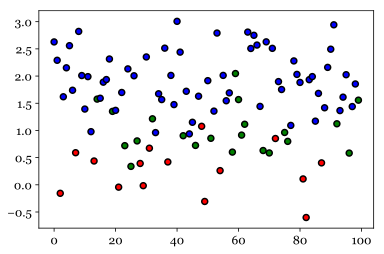

In [132]:
plt.scatter(np.arange(len(ys)), ys, color = np.array(['r', 'g', 'b'])[xs],
            marker='o', linewidth=1.5, edgecolor='black')
plt.show()

In [133]:
sig_noise = 1
sig_trans = 1
lamda = 0.99
coeff = 1

no_points = 100
xs = [np.random.normal(0, sig_trans)]
ys = [np.random.normal(coeff*xs[-1], sig_noise)]

for n in range(no_points):
    x_ = np.random.normal(lamda*xs[-1], sig_trans)
    y_ = np.random.normal(coeff*xs[-1], sig_noise)
    
    xs.append(x_)
    ys.append(y_)

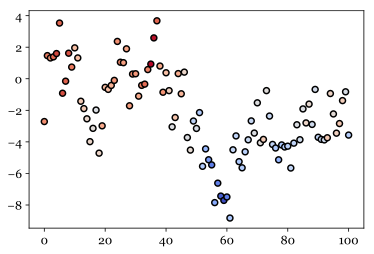

In [134]:
plt.scatter(np.arange(len(ys)), ys, c = xs, cmap = 'coolwarm',
            marker='o', linewidth=1.5, edgecolor='black')
plt.show()